In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Adamovich_BRCA1_HDR"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [4]:
AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [5]:
AUTHOR_TRANSCRIPT

'NM_007294'

# Add ClinVar annotations

In [6]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

100%|██████████| 7254/7254 [00:03<00:00, 1920.21it/s]


In [7]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [8]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [9]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [10]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [11]:
scoreset_processed

,hgvs_pro,Codon,AA,variantID,FS1_BRCA1_siRNA,FS2_BRCA1_siRNA,FS3_BRCA1_siRNA,FS4_BRCA1_siRNA,score,std_BRCA1_siRNA,var_BRCA1_siRNA,FS1_control_siRNA,FS2_control_siRNA,FS3_control_siRNA,FS4_control_siRNA,FS_average_control_siRNA,std_control_siRNA,var_control_siRNA,author_transcript,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Ser1577Ter,1577,*,S1577*,-1.241804,-1.550598,-0.495599,-0.985481,-1.068371,0.446303,0.199187,-0.581768,-0.849583,-0.021240,-0.080560,-0.383288,0.399812,0.159849,NM_007294.4,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ser1577Ala,1577,A,S1577A,-0.331300,-0.402713,-0.536221,0.338348,-0.232972,0.390234,0.152282,-0.133324,-0.171026,-0.081711,0.357707,-0.007089,0.245937,0.060485,NM_007294.4,False,False,0.0,0.0,0.0,1.0,NM_007294.4(BRCA1):c.4729T>G (p.Ser1577Ala),1.0,0.0,NaN,NaN,NaN
2,p.Ser1577Phe,1577,F,S1577F,-0.022754,-0.458886,-0.002527,0.007973,-0.119049,0.226917,0.051491,-0.047452,-0.318764,-0.356480,-0.036659,-0.189839,0.171396,0.029376,NM_007294.4,False,False,0.0,0.0,0.0,1.0,NM_007294.4(BRCA1):c.4730C>T (p.Ser1577Phe),1.0,0.0,6.840510e-07,0.0,17:43071184:G:A|17:43071184:G:A
3,p.Ser1577Ile,1577,I,S1577I,0.037731,-0.427296,-0.170152,-0.242601,-0.200579,0.192253,0.036961,-0.616898,0.127038,-0.992783,0.347681,-0.283741,0.627473,0.393723,NM_007294.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Ser1577Leu,1577,L,S1577L,-0.376957,-0.272673,-0.155513,-0.161268,-0.241602,0.105121,0.011050,0.261911,-0.035564,-0.120263,0.140842,0.061732,0.172161,0.029640,NM_007294.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,p.Tyr1863Pro,1863,P,Y1863P,0.342841,0.325277,-0.607703,0.412850,0.118316,0.485489,0.235700,0.170588,0.141004,0.746013,-0.408677,0.162232,0.471613,0.222419,NM_007294.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2267,p.Tyr1863Gln,1863,Q,Y1863Q,0.207516,0.023562,-0.167064,-0.222917,-0.039726,0.195711,0.038303,0.053818,0.283379,0.223642,0.292357,0.213299,0.110608,0.012234,NM_007294.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2268,p.Tyr1863Arg,1863,R,Y1863R,0.096732,-0.349574,0.052473,-0.293663,-0.123508,0.230603,0.053178,0.015346,-0.149157,-0.162151,-0.307390,-0.150838,0.131980,0.017419,NM_007294.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2269,p.Tyr1863Ser,1863,S,Y1863S,0.266307,-0.014909,-0.019175,-0.009879,0.055586,0.140532,0.019749,0.339735,-0.030926,0.038621,0.093333,0.110191,0.161256,0.026004,NM_007294.4,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [13]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [14]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [15]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
}

In [16]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 39
B/LB: 31
gnomAD: 140


(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>], dtype=object))

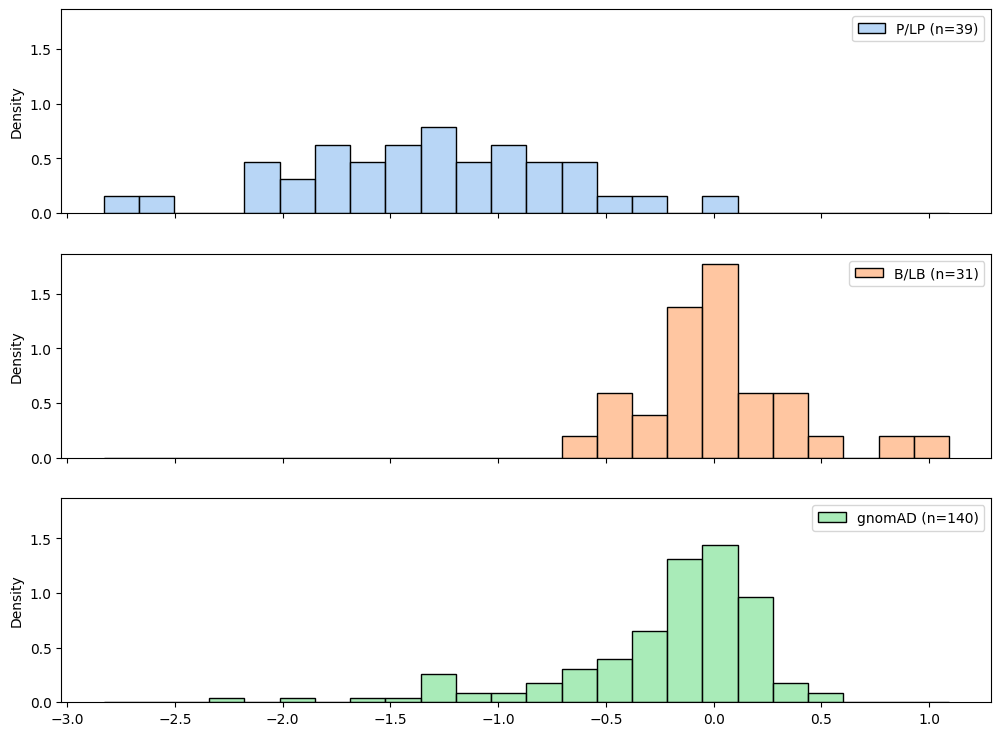

In [17]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [18]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)